### Loading in all training and evaluation data

In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d

tr_data = []  # Empty list to hold TR data
vl_data = []  # Empty list to hold VL data
memorization_score = []  # Empty list to hold memorization scores

# get the home directory
home_dir = os.path.expanduser('~')
os.chdir(os.path.join(home_dir, 'bench/aiConfidential'))  # Change directory to the root of the repository

data_path = 'data' 

# Walk through all directories and subdirectories in the 'data' folder
for root, dirs, files in os.walk(data_path):
    if '_upsample' not in root and (root.endswith('_TR.eval') or root.endswith('_VL.eval')): # Check if we are in a TR.eval or VL.eval folder
        for file in files:
            if file.startswith('eval_loss_meta'): # Check if the file is 'eval_loss_meta'
                file_path = os.path.join(root, file)
                # Read the file into a DataFrame
                try: 
                    df = pd.read_csv(file_path)
                # Append to the appropriate list
                    if root.endswith('_TR.eval'):
                        tr_data.append(df)
                    elif root.endswith('_VL.eval'):
                          vl_data.append(df)
                except:
                    print(f'Error reading {file_path}')
                
                
# Concatenate all dataframes into one for TR and one for VL
tr_df = pd.concat(tr_data, ignore_index=True)
vl_df = pd.concat(vl_data, ignore_index=True)

with open(os.path.join(data_path, 'nr80-vs-nr80.rnaforester.alnIdentity_pairwise.pkl'), 'rb') as file:
    data = pickle.load(file)

pickle_df = pd.DataFrame(data)  # Renamed file to 'pickle_df' and converting to pandas
pickle_df.index = pickle_df.index.map(lambda x: str(x).split('_', 1)[0]) # Rename idx values to stop before the first underscore so idx values match up to memorization score data
pickle_df.columns = pickle_df.columns.map(lambda x: str(x).split('_', 1)[0])

### Calculating the Relative memorization score for every index, only for high performing points

In [ ]:
#Avergaing the f1 scores for each idx in both the TR and VL dataframes
tr_avg_f1 = tr_df.groupby(['idx', 'moltype'])['f1'].mean().reset_index() #Keeping moltype column
tr_avg_f1.rename(columns={'f1': 'tr_avg_f1'}, inplace=True)
vl_avg_f1 = vl_df.groupby(['idx'])['f1'].mean().reset_index()
vl_avg_f1.rename(columns={'f1': 'vl_avg_f1'}, inplace=True)

memscore_df = pd.merge(tr_avg_f1, vl_avg_f1, on='idx')# Combining the TR and VL dataframes into one
# Get memorization score. This time this is the Relative Memscore (TR_F1 - VL_F1)/(TR_F1 + VL_F1), and removes underperfroming models
memscore_df['mem_score'] = (memscore_df['tr_avg_f1'] - memscore_df['vl_avg_f1'])
memscore_df['mem_score2'] = (memscore_df['tr_avg_f1'] - memscore_df['vl_avg_f1'])/((memscore_df['tr_avg_f1'] + memscore_df['vl_avg_f1'])) # Subtract the VL F1 score from the TR F1 score for each idx
memscore_df= memscore_df[memscore_df['tr_avg_f1'] >= 0.9] # Remove any rows where the TR F1 score is less than 0.7
#   memscore_df= memscore_df[memscore_df['tr_avg_f1'] <= 0.995] # Remove any rows where the TR F1 score is greater than 0.99
print(memscore_df)


        idx   moltype  tr_avg_f1  vl_avg_f1  Memorization_Score
36    12327  16S-rRNA   0.929907   0.639932        1.847163e-01
44    12609   5S-rRNA   0.991521   0.925347        3.452167e-02
45    12612   5S-rRNA   0.985929   0.975419        5.358582e-03
46    12615   5S-rRNA   0.977028   0.895929        4.329967e-02
47    12620   5S-rRNA   0.989931   0.920768        3.619760e-02
...     ...       ...        ...        ...                 ...
2838  40605      tRNA   0.998677   0.867635        7.021447e-02
2839  40615      tRNA   0.992850   0.977049        8.021172e-03
2840  40616      tRNA   0.999634   0.970385        1.484734e-02
2841  40620      tRNA   0.985588   0.924989        3.171750e-02
2842  40623      tRNA   0.999995   0.999993        6.119528e-07

[1692 rows x 5 columns]


## Kernal Density Function

In [47]:
def kde(row):  # KDE function
    sigma = np.std(row)
    mu = np.mean(row)
    f = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((row - mu) ** 2) / sigma ** 2)
    return f 

kde_scores = {}

for idx, row in pickle_df.iterrows():
    row_values = row.values
    kde_values = kde(row_values)  # Vectorized KDE for the entire row
    kde_scores[idx] = np.mean(kde_values)  # Compute the mean KDE score for the row

# Convert the results to a DataFrame
kde_scores_df = pd.DataFrame(list(kde_scores.items()), columns=['idx', 'similarity_score'])
print(kde_scores_df)


        idx  similarity_score
0     34661          1.943766
1     31262          1.820706
2     37294          7.002997
3     34263          1.957522
4     27176          3.141671
...     ...               ...
3408  26367          2.554117
3409  31446          2.031365
3410  28360          1.942502
3411  27863          2.069014
3412  17264          2.410071

[3413 rows x 2 columns]


/Users/ilanastern/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


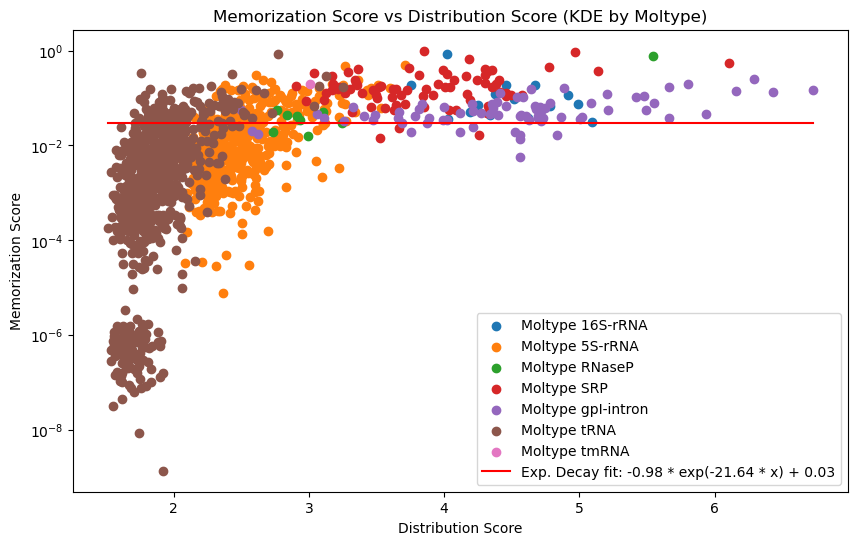

The exponential decay equation is: y = -0.98 * e^(-21.64 * x) + 0.03


/var/folders/51/q3b3fr414sd415d3n6_75k180000gn/T/ipykernel_33809/1093427492.py:8: RuntimeWarning: invalid value encountered in multiply
  return a * np.exp(-b * x) + c


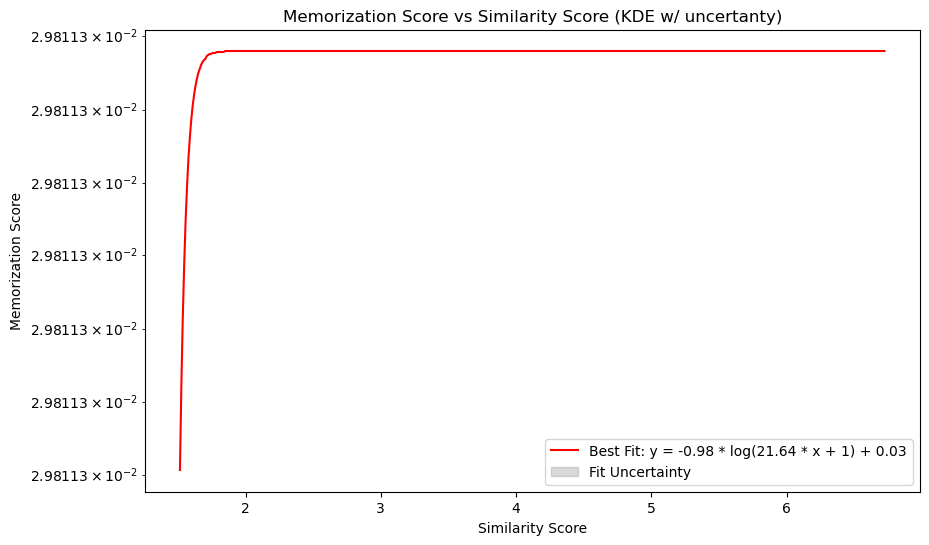

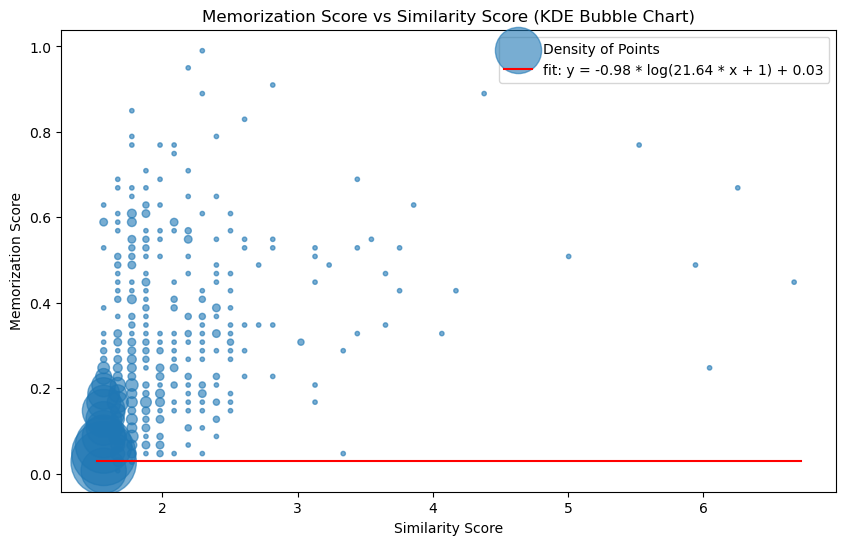

In [48]:
memscore_df['idx'] = memscore_df['idx'].astype(str) # Ensuring both DataFrames have the same data type for the 'idx' column
kde_scores_df['idx'] = kde_scores_df['idx'].astype(str)

merged_df = pd.merge(memscore_df, kde_scores_df, on='idx', how='inner') # Merging the two DataFrames so each 'idx' has a memorization score and a similarity score
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['similarity_score', 'Memorization_Score']) # Remove rows with infinite values or NaN

def exp_decay(x, a, b, c): # Exponential decay function to fit the data
    return a * np.exp(-b * x) + c

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
initial_guess = [1, 1, 1]  # Initial guess for parameters a, b, c
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500)
y_fit = exp_decay(x_fit, *params)

moltypes = merged_df['moltype'].unique()  # Get unique moltypes
color_map = {moltype: color for moltype, color in zip(moltypes, plt.cm.tab10.colors[:len(moltypes)])}
# Plotting moltypes and all data points against the fitted curve
plt.figure(figsize=(10, 6))
for moltype in moltypes:
    subset = merged_df[merged_df['moltype'] == moltype]
    plt.scatter(subset['similarity_score'], subset['Memorization_Score'],
                color=color_map[moltype], label=f'Moltype {moltype}')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score (KDE by Moltype)')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')

# Best Fit Line with Error Bars
plt.figure(figsize=(10, 6))
perr = np.sqrt(np.diag(covariance))  # Calculate standard deviation of parameters
y_err = exp_decay(x_fit, *(params + perr)) - exp_decay(x_fit, *params)  # Error bars
plt.plot(x_fit, y_fit, color='red', label=f'Best Fit: y = {params[0]:.2f} * log({params[1]:.2f} * x + 1) + {params[2]:.2f}')
plt.fill_between(x_fit, y_fit - y_err, y_fit + y_err, color='gray', alpha=0.3, label='Fit Uncertainty')
plt.xlabel('Similarity Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Similarity Score (KDE w/ uncertanty)')
plt.legend()
plt.show()

# Plotting Bubble Chart to show density of points
plt.figure(figsize=(10, 6))
density, x_edges, y_edges = np.histogram2d(x, y, bins=50)
x_center = (x_edges[:-1] + x_edges[1:]) / 2
y_center = (y_edges[:-1] + y_edges[1:]) / 2
x_mesh, y_mesh = np.meshgrid(x_center, y_center)
plt.scatter(x_mesh.ravel(), y_mesh.ravel(), s=density.ravel() * 10, alpha=0.6, label='Density of Points')
plt.plot(x_fit, y_fit, color='red', label=f'fit: y = {params[0]:.2f} * log({params[1]:.2f} * x + 1) + {params[2]:.2f}')
plt.xlabel('Similarity Score')
plt.ylabel('Memorization Score')
plt.title('Memorization Score vs Similarity Score (KDE Bubble Chart)')
plt.legend()
plt.show()


## Graphing the Expoential Decay Sim. Score

In [49]:
# Constants for the exponential decay function that I used to model the distribution scores, Values closest to 1 have the highest points (10)
#The function is A * exp(-B * (1 - score)) Values of 0.9 are worth 1 point. A score of 0 is worth 0 points.
A = 10  # Maximum points for the highest score (close to 1)
B = np.log(A ) / (1 - 0.85)  # Solve for B based on the condition that 0.85 maps to 1 point

def map_similarity_to_points(score): # Function to map similarity score to points based on the new rules
    if pd.isna(score):  # Ignore NaN values
        return 0
    elif score >= 1:  # Ignore scores that are 1 or greater
        return 0
    elif score < 0.0:  # Return 0 points for scores less than 0
        return 0
    else:  # Apply the exponential decay function for scores between 0 and 1
        return  A * np.exp(-B * (1 - score))

similarity_scores = {} # Empty dictionary to hold similarity scores

for idx, row in pickle_df.iterrows(): # Iterate over each row (which corresponds to an 'idx')
    points = row.apply(map_similarity_to_points).sum() # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    similarity_scores[idx] = points # Store the total points as the overall similarity score for each idx

similarity_scores_df = pd.DataFrame(list(similarity_scores.items()), columns=['idx', 'similarity_score']) # Convert the results to a DataFrame

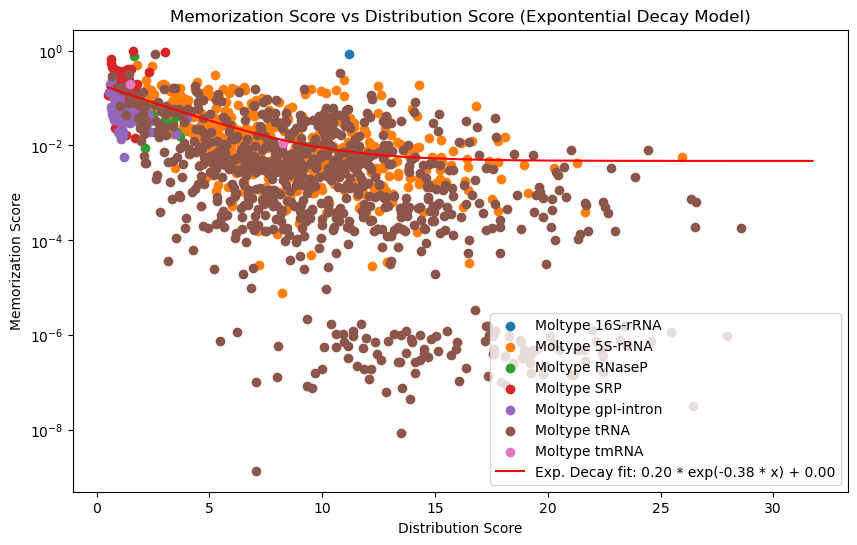

The exponential decay equation is: y = 0.20 * e^(-0.38 * x) + 0.00


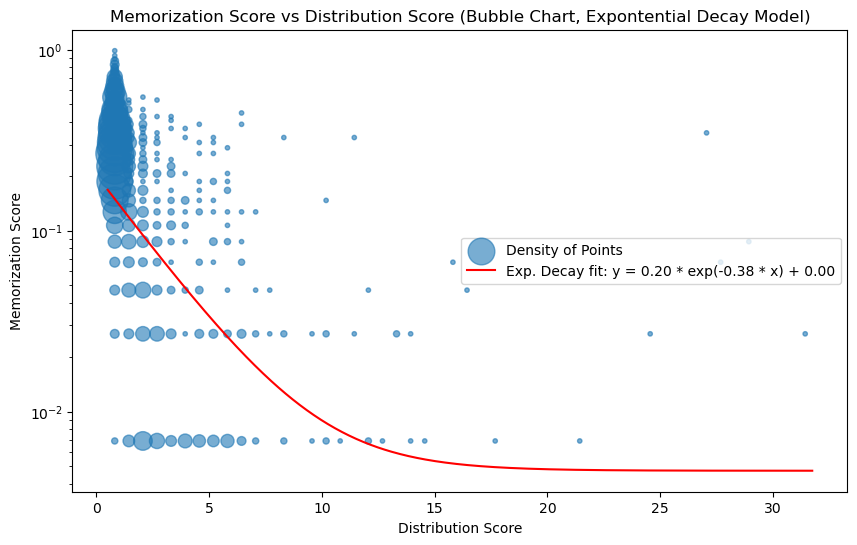

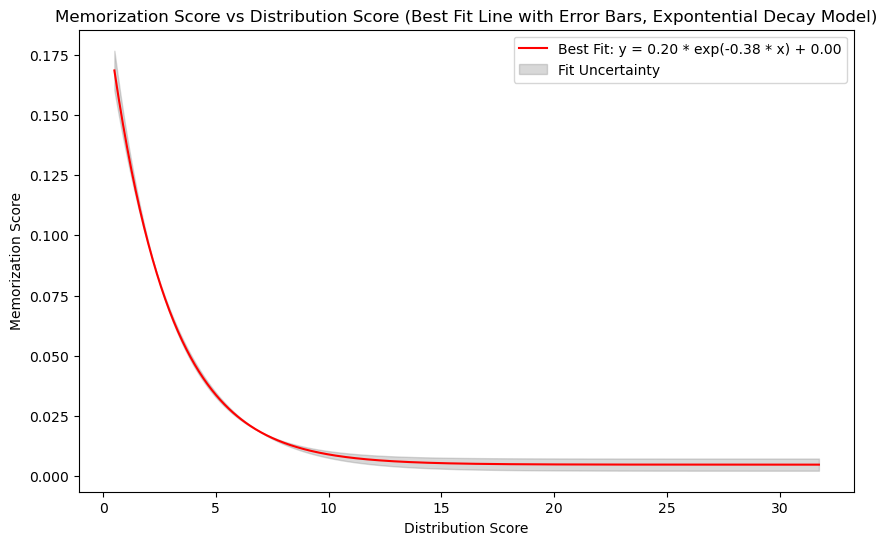

In [50]:
memscore_df['idx'] = memscore_df['idx'].astype(str) #ensuring both dataframes have the same data type for the idx column
similarity_scores_df['idx'] = similarity_scores_df['idx'].astype(str)

# Merging the two dataframes so each idx has a memorization score and a similarity score
merged_df = pd.merge(memscore_df, similarity_scores_df, on='idx', how='inner')

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)
moltypes = merged_df['moltype'].unique()  # Get unique moltypes
color_map = {moltype: color for moltype, color in zip(moltypes, plt.cm.tab10.colors[:len(moltypes)])}

# Plotting moltypes and all data points against the fitted curve
plt.figure(figsize=(10, 6))
for moltype in moltypes:
    subset = merged_df[merged_df['moltype'] == moltype]
    plt.scatter(subset['similarity_score'], subset['Memorization_Score'],
                color=color_map[moltype], label=f'Moltype {moltype}')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score (Expontential Decay Model)')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')

# Plotting Bubble Chart to show density of points
plt.figure(figsize=(10, 6))
density, x_edges, y_edges = np.histogram2d(x, y, bins=50)
x_center = (x_edges[:-1] + x_edges[1:]) / 2
y_center = (y_edges[:-1] + y_edges[1:]) / 2
x_mesh, y_mesh = np.meshgrid(x_center, y_center)
plt.scatter(x_mesh.ravel(), y_mesh.ravel(), s=density.ravel()*10, alpha=0.6, label='Density of Points')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score (Bubble Chart, Expontential Decay Model)')
plt.legend()
plt.show()

# Best Fit Line with Error Bars
plt.figure(figsize=(10, 6))
perr = np.sqrt(np.diag(covariance)) # Calculate the standard deviation of the parameters
plt.plot(x_fit, y_fit, color='red', label=f'Best Fit: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
y_err = exp_decay(x_fit, *(params + perr)) - exp_decay(x_fit, *params) # Add error bars for the fit
plt.fill_between(x_fit, y_fit - y_err, y_fit + y_err, color='gray', alpha=0.3, label='Fit Uncertainty')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.title('Memorization Score vs Distribution Score (Best Fit Line with Error Bars, Expontential Decay Model)')
plt.legend()
plt.show()




## Simmilarity Score as Number Points within a certain closness range

In [56]:
def quanta_simscore(score): # Function to map similarity score to points based on the new rules
    if score > 0.4:  #Only add a point if the simmialrity score is greater than 0.7
        return 1

sim_score_quanta = {} # Empty dictionary 

for idx, row in pickle_df.iterrows(): # Iterate over each row
    points = row.apply(quanta_simscore).sum() # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    similarity_scores[idx] = points # Store the total points as the overall similarity score for each idx

quanta_simscore_df = pd.DataFrame(list(similarity_scores.items()), columns=['idx', 'similarity_score']) # Convert the results to a DataFrame
print(quanta_simscore_df)

        idx  similarity_score
0     34661            1175.0
1     31262            1291.0
2     37294              18.0
3     34263            1134.0
4     27176             129.0
...     ...               ...
3408  26367             355.0
3409  31446             856.0
3410  28360             959.0
3411  27863             959.0
3412  17264             685.0

[3413 rows x 2 columns]


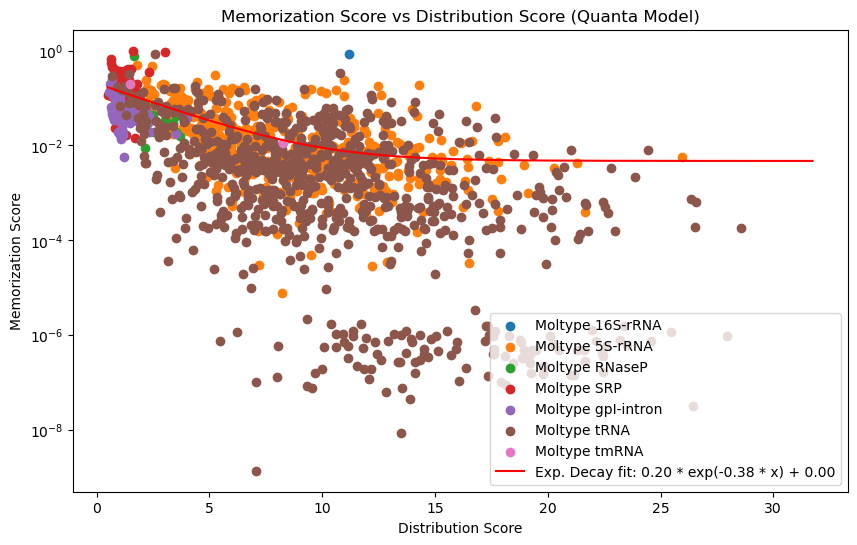

The exponential decay equation is: y = 0.20 * e^(-0.38 * x) + 0.00


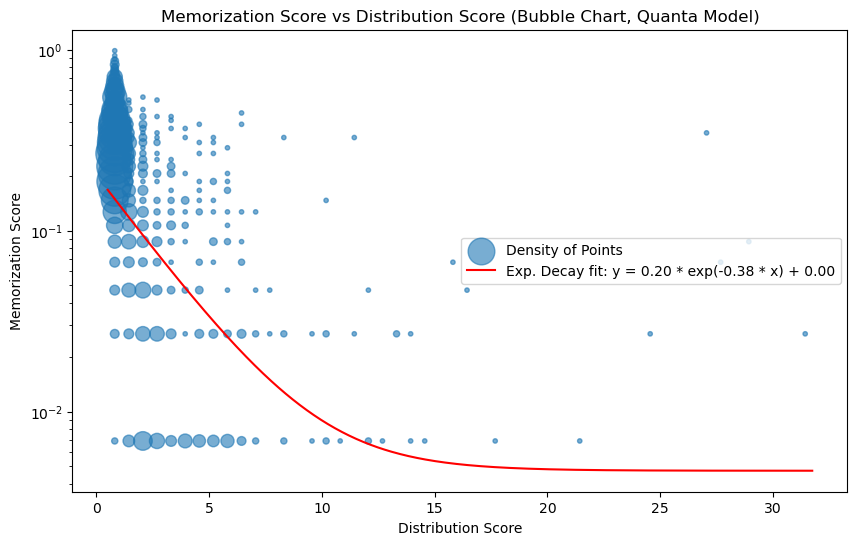

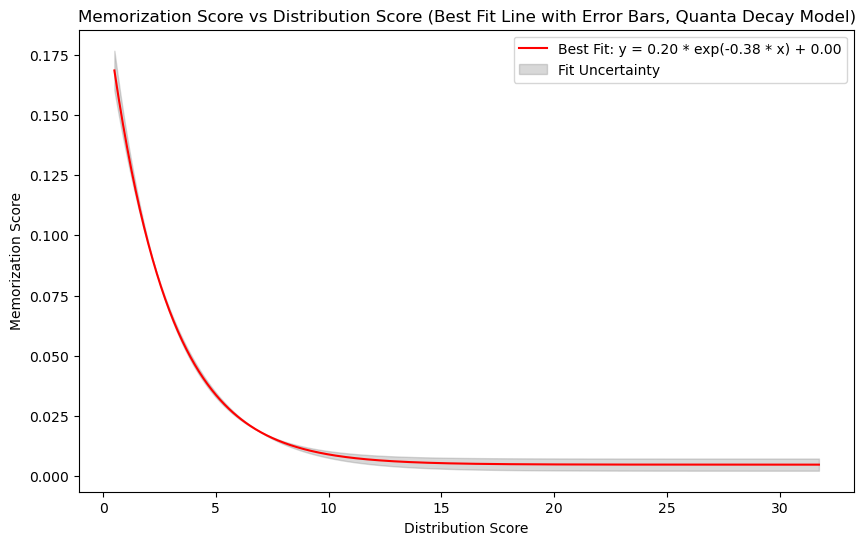

In [58]:
memscore_df['idx'] = memscore_df['idx'].astype(str) #ensuring both dataframes have the same data type for the idx column
quanta_simscore_df['idx'] = quanta_simscore_df['idx'].astype(str)
merged_df = pd.merge(memscore_df, similarity_scores_df, on='idx', how='inner')

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)
moltypes = merged_df['moltype'].unique()  # Get unique moltypes
color_map = {moltype: color for moltype, color in zip(moltypes, plt.cm.tab10.colors[:len(moltypes)])}

# Plotting moltypes and all data points against the fitted curve
plt.figure(figsize=(10, 6))
for moltype in moltypes:
    subset = merged_df[merged_df['moltype'] == moltype]
    plt.scatter(subset['similarity_score'], subset['Memorization_Score'],
                color=color_map[moltype], label=f'Moltype {moltype}')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score (Quanta Model)')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')

# Plotting Bubble Chart to show density of points
plt.figure(figsize=(10, 6))
density, x_edges, y_edges = np.histogram2d(x, y, bins=50)
x_center = (x_edges[:-1] + x_edges[1:]) / 2
y_center = (y_edges[:-1] + y_edges[1:]) / 2
x_mesh, y_mesh = np.meshgrid(x_center, y_center)
plt.scatter(x_mesh.ravel(), y_mesh.ravel(), s=density.ravel()*10, alpha=0.6, label='Density of Points')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score (Bubble Chart, Quanta Model)')
plt.legend()
plt.show()

# Best Fit Line with Error Bars
plt.figure(figsize=(10, 6))
perr = np.sqrt(np.diag(covariance)) # Calculate the standard deviation of the parameters
plt.plot(x_fit, y_fit, color='red', label=f'Best Fit: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
y_err = exp_decay(x_fit, *(params + perr)) - exp_decay(x_fit, *params) # Add error bars for the fit
plt.fill_between(x_fit, y_fit - y_err, y_fit + y_err, color='gray', alpha=0.3, label='Fit Uncertainty')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.title('Memorization Score vs Distribution Score (Best Fit Line with Error Bars, Quanta Decay Model)')
plt.legend()
plt.show()


